In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors
from glob import glob
from tqdm import tqdm

## Plot Config

In [2]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
    "acsincome" : "ACSIncome",
    "taiwan" : "Taiwan Credit",
}
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "LGBMRegressor" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "FairGBMClassifier_eod" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "MinMaxFairRegressor" : "#a6d854",
    "MinMaxFair_tpr" : "#a6d854",
    "MinMaxFairRegressor" : "#a6d854",
    "M2FGBClassifier" : "#8da0cb",
    "M2FGBClassifier_v1" : "#8da0cb",
    "M2FGBClassifier_tpr" : "#8da0cb",
    "M2FGBClassifier_pr" : "#8da0cb",
    "M2FGBRegressor" : "#8da0cb",
    "MinimaxPareto" : "pink"
}
methods_names = {
    "LGBMClassifier" : "LGBM",
    "LGBMRegressor" : "LGBM",
    "FairGBMClassifier" : "FairGBM",
    "FairGBMClassifier_eod" : "FairGBM (eod)",
    "M2FGBClassifier_tpr" : "M²FGB (tpr)",
    "M2FGBClassifier_pr" : "M²FGB (pr)",
    "M2FGBClassifier" : "M²FGB",
    "M2FGBRegressor" : "M²FGB",
    "MinMaxFair" : "MinMaxFair",
    "MinMaxFair_tpr" : "MinMaxFair (tpr)",
    "MinimaxPareto" : "MMPF",
    "MinMaxFairRegressor" : "MinMaxFair",
}

handles = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" not in key and "pr" not in key and "eod" not in key
]

handles_tpr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" in key or "LGBM" in key or "eod" in key
]
handles_pr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "_pr" in key or "LGBM" in key
]

## Functions

In [3]:
SEED = 0

## $\lambda$ parameter

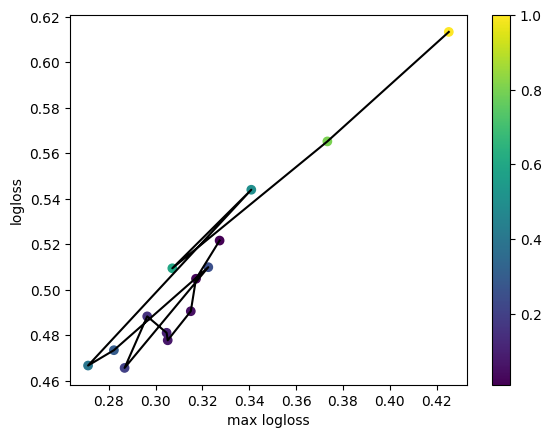

In [139]:
results = pd.read_csv("../results_aaai/experiment_new/fair_weight/german_4g/M2FGBClassifier_tpr/train.csv")
trials = pd.read_csv("../results_aaai/experiment_new/fair_weight/german_4g/M2FGBClassifier_tpr/trials.csv")
results = results.merge(trials)

# groupby by fair_weight and average
results["fair_weight"] = results.params_fair_weight

# remove row with inf values
# results = results.replace([np.inf, -np.inf], np.nan)
# results = results.dropna()

# remove non numeric cols
results = results.select_dtypes(include=[np.number])

results = results.groupby("fair_weight").mean().reset_index()
#results = results[results.fair_weight < 0.5]

plt.scatter(results.max_logloss_tpr, results.logloss, c=results.fair_weight, cmap="viridis")
plt.plot(results.max_logloss_tpr, results.logloss, c="black")
plt.xlabel("max logloss")
plt.ylabel("logloss")
plt.colorbar()

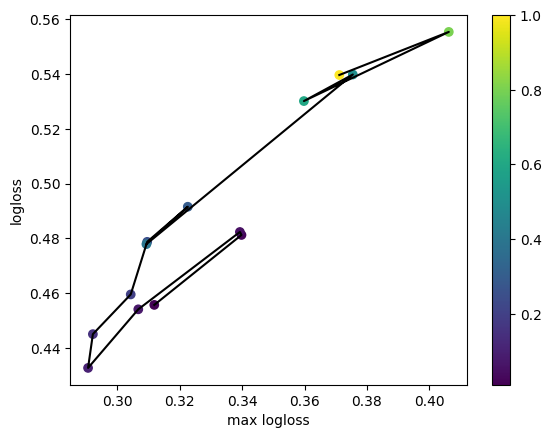

In [135]:
results = pd.read_csv("../results_aaai/experiment_new/fair_weight/german_4g/M2FGBClassifier_tpr/train.csv")
trials = pd.read_csv("../results_aaai/experiment_new/fair_weight/german_4g/M2FGBClassifier_tpr/trials.csv")
results = results.merge(trials)

# groupby by fair_weight and average
results["fair_weight"] = results.params_fair_weight

# remove row with inf values
# results = results.replace([np.inf, -np.inf], np.nan)
# results = results.dropna()

# remove non numeric cols
results = results.select_dtypes(include=[np.number])

results = results.groupby("fair_weight").mean().reset_index()
#results = results[results.fair_weight < 0.5]

plt.scatter(results.max_logloss_tpr, results.logloss, c=results.fair_weight, cmap="viridis")
plt.plot(results.max_logloss_tpr, results.logloss, c="black")
plt.xlabel("max logloss")
plt.ylabel("logloss")
plt.colorbar()

In [ ]:
norm=matplotlib.colors.Normalize(0, 1)
#norm=matplotlib.colors.Normalize(0,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#fb9a99","#1f78b4"])

fig, axs = plt.subplots(nrows =1, ncols = 3, figsize = (14, 4))

for i, dataset in enumerate(["german_4", "compas_4", "enem_8", "acsincome_8"]):
    results = pd.read_csv(f"../results_aaai/experiment_new/fair_weight/{dataset}g/M2FGBClassifier_tpr/train.csv")
    trials = pd.read_csv(f"../results_aaai/experiment_new/fair_weight/{dataset}g/M2FGBClassifier_tpr/trials.csv")
    results = results.merge(trials)

    results["fair_weight"] = results.params_fair_weight
    results = results.loc[:, results.dtypes == "float"].groupby("fair_weight").mean().reset_index()

    n_groups = int(dataset.split("_")[1])
    dataset = dataset.split("_")[0]
    
    cm = axs[i].scatter(
        results.max_logloss_tpr,
        results.logloss,
        c = results.fair_weight,
        cmap = cmap,
        norm = norm,
        zorder = 100,
        s = 75,
        ec = "#303030",
    )

    axs[i].plot(
        results.max_logloss_tpr,
        results.logloss,
        c = "#606060",
    )

    axs[i].set_xlabel("Max group TPR log loss")
    axs[i].set_ylabel("Overall log loss")

    axs[i].set_title(dataset_names[dataset] + f"(g = {n_groups})")

    # make x and y axis only have 4 ticks each
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    # add colorbar
    fig.colorbar(cm, ax=axs[i], label="$\lambda$")

plt.tight_layout()

#plt.savefig("../figs/fair_weight.pdf", dpi = 300)
plt.show()




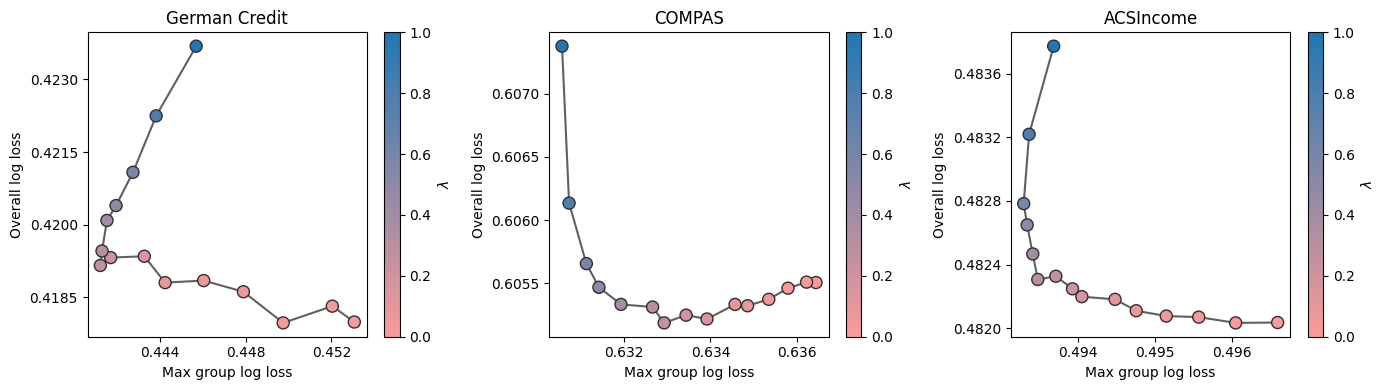

In [8]:
norm=matplotlib.colors.Normalize(0, 1)
#norm=matplotlib.colors.Normalize(0,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#fb9a99","#1f78b4"])

fig, axs = plt.subplots(nrows =1, ncols = 3, figsize = (14, 4))

for i, dataset in enumerate(["german", "compas", "acsincome"]):
    results = pd.read_csv(f"../results/experiment_fair_weight/{dataset}.csv")
    results = results.loc[:, results.dtypes == "float"].groupby("fair_weight").mean().reset_index()
    #results = results[results.fair_weight > 0]

    
    cm = axs[i].scatter(
        results.max_group_score,
        results.overall_score,
        c = results.fair_weight,
        cmap = cmap,
        norm = norm,
        zorder = 100,
        s = 75,
        ec = "#303030",
    )

    axs[i].plot(
        results.max_group_score,
        results.overall_score,
        c = "#606060",
    )

    axs[i].set_xlabel("Max group log loss")
    axs[i].set_ylabel("Overall log loss")

    axs[i].set_title(dataset_names[dataset])

    # make x and y axis only have 4 ticks each
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    # add colorbar
    fig.colorbar(cm, ax=axs[i], label="$\lambda$")

plt.tight_layout()

plt.savefig("../figs/fair_weight.pdf", dpi = 300)
plt.show()




## new version

In [76]:
def summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    experiment_folder = "../results_aaai/experiment_new",
    n_sampled = 100,
    n_repetitions = 1000,
    version = "v1",
    aux_fair_metric = None
):

    alpha_list = [i/20 for i in range(21)]
    df_results = []
    for dataset in dataset_list:
        for model in method_list:
            try:
                #results_train = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/train.csv")
                results_val = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/val.csv")
                results_test = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/test.csv")

                print(f"Total models for {model}, {dataset} : {len(results_val)}")
                #trial = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/trials.csv")
                #for col in [col for col in trial.columns if "params_" in col]:
                #    results_test[col] = trial[col]
                #results_train["duration"] = pd.to_timedelta(results_train["duration"]).dt.total_seconds()
                results_val["duration"] = pd.to_timedelta(results_val["duration"]).dt.total_seconds()
                results_test["duration"] = pd.to_timedelta(results_test["duration"]).dt.total_seconds()

                if version == "v2":
                    metrics_col = [col for col in results_val.columns if aux_fair_metric in col]
                    # weight metrics by the inverse of the ratio of the group size
                    for col in metrics_col:
                        digit = int(col.split("=")[-1])
                        results_val[col] = results_val[col] * results_val[f"ratio_g={digit}"]
                        results_test[col] = results_test[col] * results_test[f"ratio_g={digit}"]

                    results_val[aux_fair_metric] = results_val[metrics_col].mean(axis = 1)
                    results_test[aux_fair_metric] = results_test[metrics_col].mean(axis = 1)
                    evaluated_fair_metric = aux_fair_metric
                else:
                    evaluated_fair_metric = fair_metric


                for alpha in tqdm(alpha_list):
                    for _ in range(n_repetitions):
                        # sample models
                        results_val_sample = results_val.sample(min(n_sampled, results_val.shape[0]), replace=False)
                        # compute score
                        score = alpha * results_val_sample[evaluated_fair_metric] + (1 - alpha) * results_val_sample[perf_metric]
                        # get test result of the best model in validation

                        if version == "v3":
                            top_5_scores_idx = score.nlargest(5).index
                            # random choice one
                            best_model = results_test.loc[np.random.choice(top_5_scores_idx)]
                        else:
                            best_model = results_test.loc[score.idxmax()]
                        #best_model = results_val.loc[score.idxmax()]


                        df_results.append({
                            "dataset" : dataset,
                            "model" : model,
                            "alpha" : alpha,
                            "eval_fair_metric" : best_model[evaluated_fair_metric],
                            perf_metric : best_model[perf_metric],
                            fair_metric : best_model[fair_metric],
                            "duration" : best_model.duration,
                        })
            except:
                print(f"Error in {model}, {dataset}")
    df_results = pd.DataFrame(df_results)
    #df_results_std = df_results.groupby(["dataset", "model", "alpha"]).std().reset_index()
    df_results = df_results.groupby(["dataset", "model", "alpha"]).mean().reset_index()
    return df_results

In [23]:
def plot_results(axs, df_results):
    model_list = df_results.model.unique()
    for i, model in enumerate(model_list):
        df_results_filter = df_results[df_results.model == model]
        #df_results_filter_std = df_results_std[df_results_std.model == model]

        axs[0].plot(
            df_results_filter.alpha,
            df_results_filter[perf_metric],
            c = methods_color[model],
        )
        axs[0].set_ylabel(perf_metric)
        axs[0].set_xlabel("alpha")

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[perf_metric] - 1.96 * df_results_filter_std[perf_metric],
        #     df_results_filter[perf_metric] + 1.96 * df_results_filter_std[perf_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )

        

        axs[1].plot(
            df_results_filter.alpha,
            df_results_filter[fair_metric],
            linestyle = "--",
            c = methods_color[model],
        )
        axs[1].set_ylabel(fair_metric)
        axs[1].set_xlabel("alpha")

        

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[fair_metric] - 1.96 * df_results_filter_std[fair_metric],
        #     df_results_filter[fair_metric] + 1.96 * df_results_filter_std[fair_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )   
        axs[2].plot(
            df_results_filter[perf_metric],
            df_results_filter[fair_metric],
            c = methods_color[model],
            label = model,
            #s = 25,
            marker = "o",
            linestyle = "",
        )
        axs[2].set_xlabel(perf_metric)
        axs[2].set_ylabel(fair_metric)

### min bal acc

In [40]:
perf_metric = "bal_acc"
fair_metric = "min_bal_acc"
aux_fair_metric = "acc_g"
dataset_list = ["compas_6g", "enem_6g"] #, "enem_large_27g"]
method_list = ["M2FGBClassifier", "LGBMClassifier", "FairGBMClassifier", "MinimaxPareto", "MinMaxFair"]
method_list = ["M2FGBClassifier", "LGBMClassifier"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    n_sampled=100,
    aux_fair_metric = aux_fair_metric,
    version = "v1"
)

Total models for M2FGBClassifier, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.35it/s]


Total models for LGBMClassifier, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.33it/s]


Total models for M2FGBClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.35it/s]


Total models for LGBMClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.35it/s]


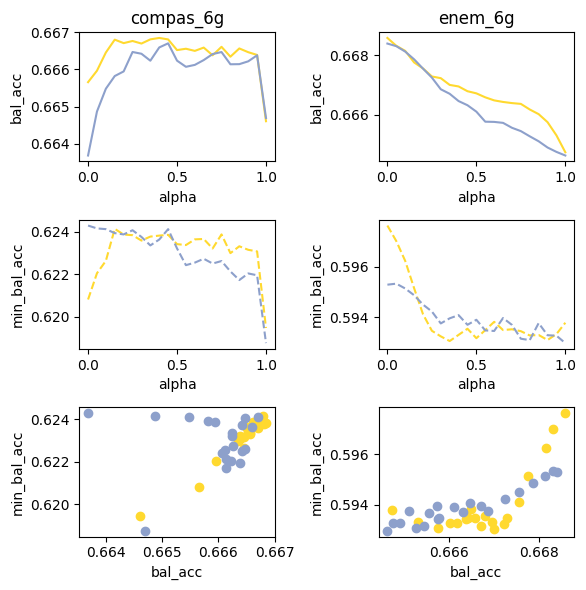

In [41]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)

plt.tight_layout()

### min acc

In [77]:
perf_metric = "acc"
fair_metric = "min_acc"
aux_fair_metric = "acc_g"
dataset_list = ["compas_6g", "enem_6g"] #, "enem_large_27g"]
method_list = ["M2FGBClassifier", "LGBMClassifier", "FairGBMClassifier", "MinimaxPareto", "MinMaxFair"]
method_list = ["M2FGBClassifier", "LGBMClassifier"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    n_sampled=100,
    aux_fair_metric = aux_fair_metric,
    version = "v3"
)

Total models for M2FGBClassifier, compas_6g : 1000


  0%|                                                                                                             | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


Total models for LGBMClassifier, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


Total models for M2FGBClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


Total models for LGBMClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


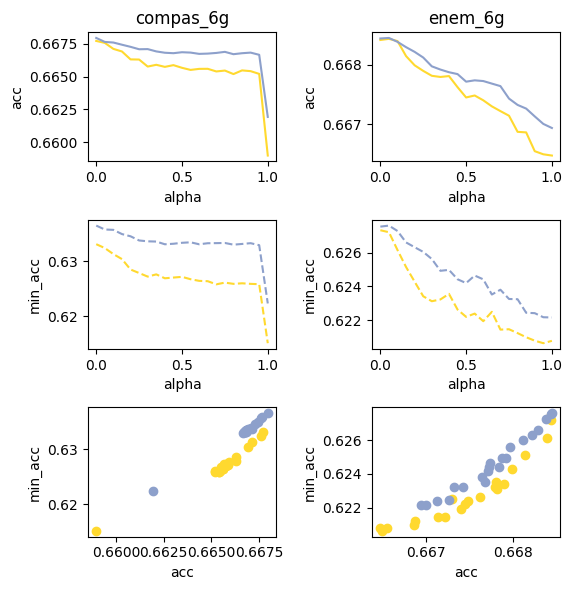

In [71]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)

plt.tight_layout()

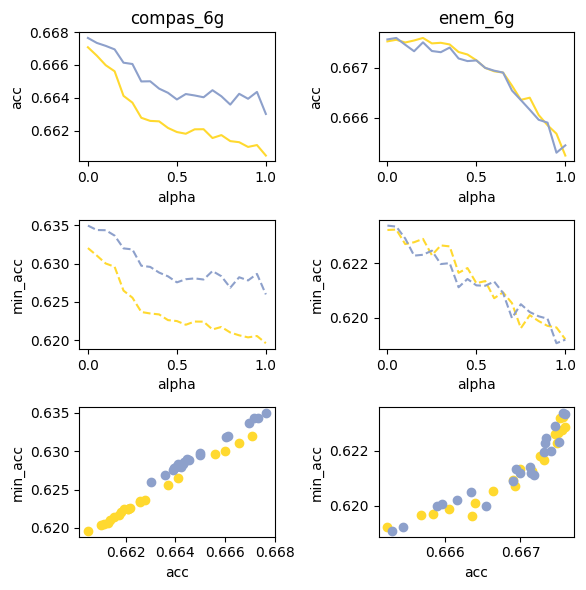

In [78]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)

plt.tight_layout()

### tpr

In [31]:
perf_metric = "acc"
fair_metric = "min_tpr"
dataset_list = ["german_6g", "compas_6g", "enem_6g"] #, "enem_large_27g"]
method_list = ["M2FGBClassifier_tpr", "LGBMClassifier"] #, "FairGBMClassifier_eod", "MinimaxPareto_tpr"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
)

Total models for M2FGBClassifier_tpr, german_6g : 1000


  0%|                                                                                                             | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.02s/it]


Total models for LGBMClassifier, german_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.04s/it]


Total models for M2FGBClassifier_tpr, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.04s/it]


Total models for LGBMClassifier, compas_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.05s/it]


Total models for M2FGBClassifier_tpr, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.04s/it]


Total models for LGBMClassifier, enem_6g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.03s/it]


In [35]:
df1 = pd.read_csv("../results_aaai/experiment_new/compas_6g/M2FGBClassifier_tpr/test.csv")
df2 = pd.read_csv("../results_aaai/experiment_new/compas_6g/M2FGBClassifier_tpr/train.csv")

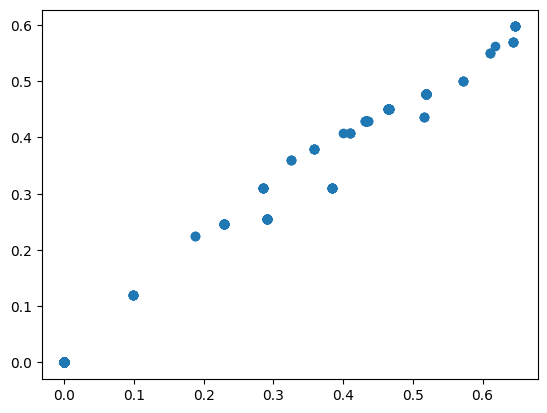

In [36]:
plt.scatter(
    df2.min_tpr,
    df1.min_tpr
)

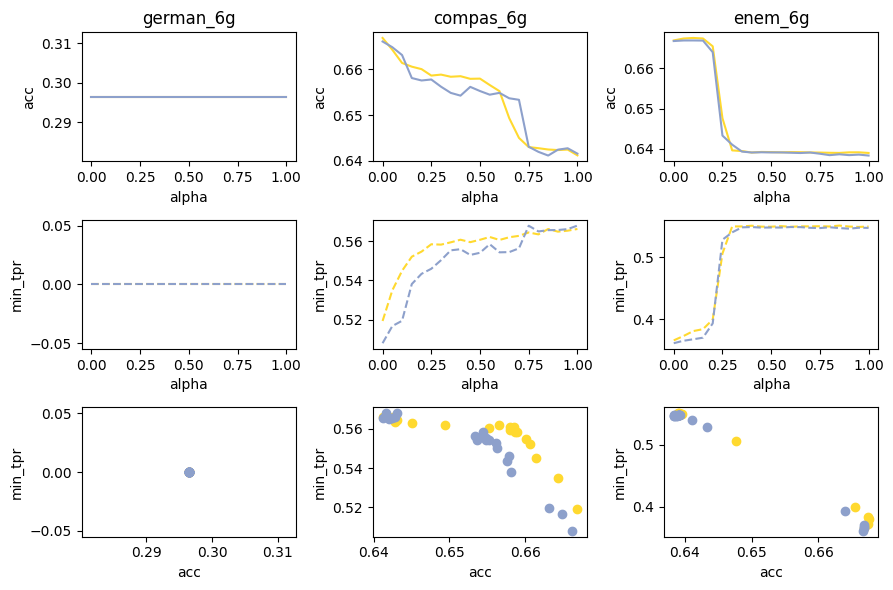

In [32]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)

plt.tight_layout()

### mse

In [100]:
perf_metric = "mse"
fair_metric = "max_mse"
experiment_folder = "../results_aaai/experiment_new" 
alpha_list = [i/20 for i in range(21)]
df_results = []
dataset_list = ["enem_reg_8g"]
method_list = ["M2FGBRegressor", "LGBMRegressor"] #, "MinMaxFairRegressor"]
n_sampled = 100
n_repetitions = 1000
for dataset in dataset_list:
    for model in method_list:
        results_train = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/train.csv")
        results_val = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/val.csv")
        results_test = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/test.csv")

        print(f"Total models for {model}, {dataset} : {len(results_val)}")
        trial = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/trials.csv")
        for col in [col for col in trial.columns if "params_" in col]:
            results_test[col] = trial[col]
        results_train["duration"] = pd.to_timedelta(results_train["duration"]).dt.total_seconds()
        results_val["duration"] = pd.to_timedelta(results_val["duration"]).dt.total_seconds()
        results_test["duration"] = pd.to_timedelta(results_test["duration"]).dt.total_seconds()

        for alpha in tqdm(alpha_list):
            for _ in range(n_repetitions):
                results_val_sample = results_val.sample(min(n_sampled, results_val.shape[0]), replace=False)
                score = alpha * -results_val_sample[fair_metric] + (1 - alpha) * -results_val_sample[perf_metric]
                best_model = results_test.loc[score.idxmax()]


                df_results.append({
                    "dataset" : dataset,
                    "model" : model,
                    "alpha" : alpha,
                    perf_metric : best_model[perf_metric],
                    fair_metric : best_model[fair_metric],
                    "duration" : best_model.duration,
                })

df_results = pd.DataFrame(df_results)
df_results_std = df_results.groupby(["dataset", "model", "alpha"]).std().reset_index()
df_results = df_results.groupby(["dataset", "model", "alpha"]).mean().reset_index()

Total models for M2FGBRegressor, enem_reg_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.22it/s]


Total models for LGBMRegressor, enem_reg_8g : 1000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


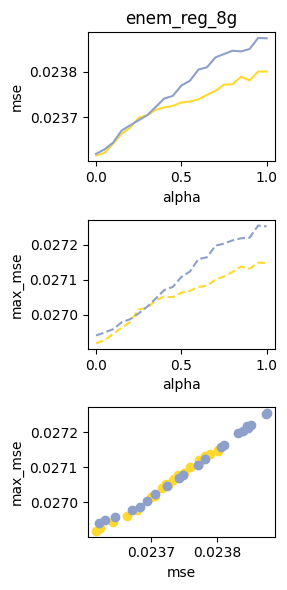

In [101]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 6))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

def plot_results(axs, df_results):
    model_list = df_results.model.unique()
    for i, model in enumerate(model_list):
    #for i, model in enumerate(["M2FGBRegressor", "LGBMRegressor"]):
        df_results_filter = df_results[df_results.model == model]
        #df_results_filter_std = df_results_std[df_results_std.model == model]

        axs[0].plot(
            df_results_filter.alpha,
            df_results_filter[perf_metric],
            c = methods_color[model],
        )
        axs[0].set_ylabel(perf_metric)
        axs[0].set_xlabel("alpha")

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[perf_metric] - 1.96 * df_results_filter_std[perf_metric],
        #     df_results_filter[perf_metric] + 1.96 * df_results_filter_std[perf_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )

        

        axs[1].plot(
            df_results_filter.alpha,
            df_results_filter[fair_metric],
            linestyle = "--",
            c = methods_color[model],
        )
        axs[1].set_ylabel(fair_metric)
        axs[1].set_xlabel("alpha")
        

        # plt.fill_between(
        #     df_results_filter.alpha,
        #     # draw 95% confidence interval
        #     df_results_filter[fair_metric] - 1.96 * df_results_filter_std[fair_metric],
        #     df_results_filter[fair_metric] + 1.96 * df_results_filter_std[fair_metric],
        #     color = methods_color[model],
        #     alpha = 0.,
        # )   
        axs[2].plot(
            df_results_filter[perf_metric],
            df_results_filter[fair_metric],
            c = methods_color[model],
            label = model,
            #s = 25,
            marker = "o",
            linestyle = "",
        )
        axs[2].set_xlabel(perf_metric)
        axs[2].set_ylabel(fair_metric)


for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset])
    axs[0, i].set_title(dataset)


plt.tight_layout()